# Plot scan

In [8]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import pandas as pd
import matplotlib.pyplot as plt
from auxPlots import interpolateData, getContours
import seaborn as sns
from nloSbottomXsec import xsecF
pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

### Load Recast Data

In [9]:
files = {'ATLAS-SUSY-2018-13' :'../results_dataFrames/pp2BB1j_2018_13.pcl',
         'ATLAS-SUSY-2016-08' :'../results_dataFrames/pp2BB1j_2016_08.pcl',
         'CMS-EXO-20-004' :'../results_dataFrames/pp2BB1j_cms.pcl',
         'CMS-EXO-20-004 (no Disp Tracks)' :'../results_dataFrames/pp2BB1j_cms_noDispTracks.pcl',}

recastDataDict = {label : pd.read_pickle(f) for label,f in files.items()}

### Compute k-factors

In [10]:
for label,df in recastDataDict.items():
    kfactors = []
    for irow,row in df.iterrows():
        msb = row['mLLP']
        xsec = row['Total xsec (pb)']
        k = xsecF(msb)/xsec
        kfactors.append(k)
    df['kfactor'] = kfactors

### Get all model points

In [11]:
msb = 'mLLP'
mn1= 'mLSP'
tau = 'tau_ns'
models = []
mCols = [msb,mn1,tau]
for recastData in recastDataDict.values():
    recastData.sort_values(mCols,inplace=True)
    for row in recastData[mCols].values:
        m = dict(zip(mCols,row.tolist()))
        if m not in models:
            models.append(m)
print('%i models loaded' %len(models))

58 models loaded


### Get Model parameters

In [12]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in [msb,mn1,tau]])

### Plot exclusion for each analysis

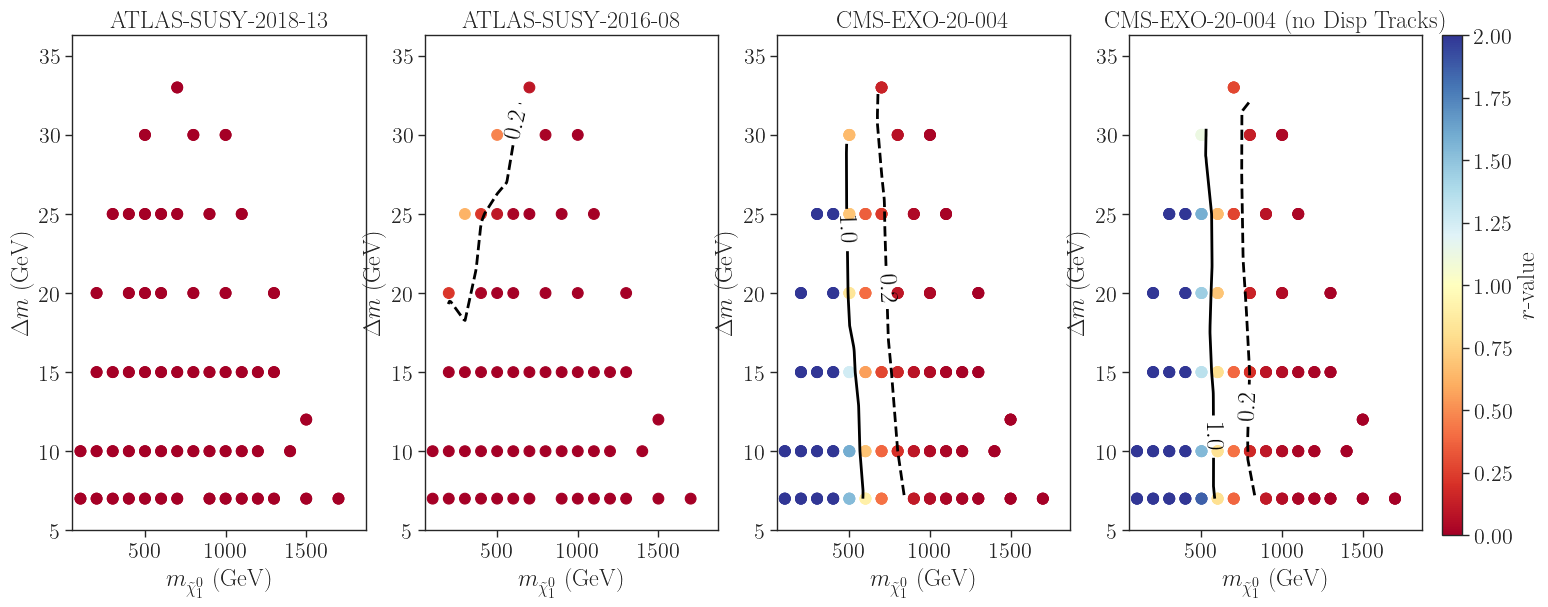

In [13]:
fig,axarr = plt.subplots(nrows=1,ncols=len(recastDataDict),figsize=(20,5))

allContours = {}
for iplot,label in enumerate(recastDataDict):
    ax = axarr[iplot]
    recastData = recastDataDict[label]
    y = recastData[msb]-recastData[mn1]
    x = recastData[mn1]
    rValues = recastData['robs']*recastData['kfactor']   
    p = ax.scatter(x=x,y=y,vmin=0.0,vmax=2.0,
            c=rValues,cmap=cm,s=60)
    
    # Interpolate to create more points
    xnew,ynew,znew = interpolateData(x,y,rValues,nx=200,ny=200)
    cValues = sorted([0.2,1.])
    # Get contours
    contours = ax.contour(xnew, ynew, znew, cValues, colors='black',linestyles=['dashed','solid'],linewidths=2.0)
    ax.clabel(contours, inline=True, fontsize=18)
    ax.set_xlabel(r'$m_{\tilde \chi_1^0}$ (GeV)')
    ax.set_ylabel(r'$\Delta m$ (GeV)')
    ax.set_title('%s' %label)
    ax.set_xlim(50.0,1.1*x.max())
    ax.set_ylim(5.0,1.1*y.max())

fig.subplots_adjust(right=0.8,top=1.1)
cbar_ax = fig.add_axes([0.81, 0.1, 0.01, 1.0]) 
fig.colorbar(p,label=r'$r$-value',cax=cbar_ax)
# plt.tight_layout()
plt.show()

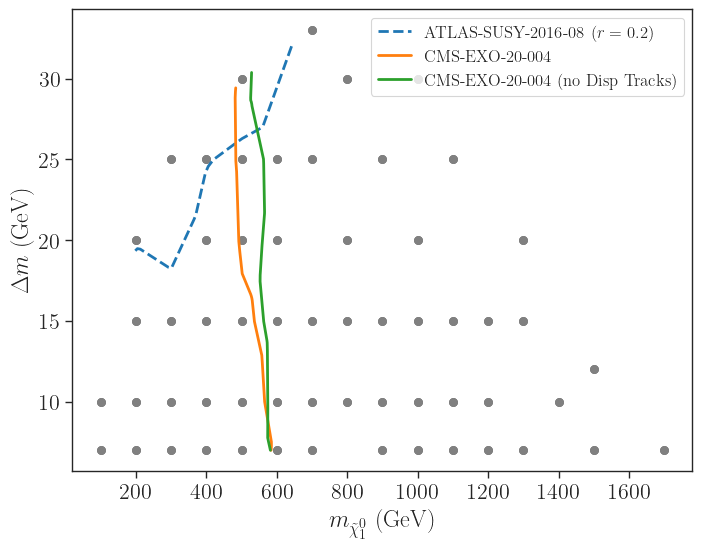

In [14]:
for label in recastDataDict:
    recastData = recastDataDict[label]
    y = recastData[msb]-recastData[mn1]
    x = recastData[mn1]
    rValues = recastData['robs']*recastData['kfactor']       
    # Interpolate to create more points
    xnew,ynew,znew = interpolateData(x,y,rValues,nx=200,ny=200)    
    allContours[label] = getContours(xnew,ynew,znew,cValues)

plt.figure(figsize=(8,6))
plt.scatter(x,y,c='gray',s=30)
for label,contours in allContours.items():
    if not contours:
        continue
    cVal = max(contours.keys())
    if cVal != 1.0:
        ls = 'dashed'
        plabel = r'%s ($r = %1.1f$)' %(label,cVal)
    else:
        ls = 'solid'
        plabel = label
    pts = contours[cVal]
    plt.plot(pts[:,0],pts[:,1],label=plabel,linewidth=2,linestyle=ls)
plt.legend(fontsize=12)
plt.xlabel(r'$m_{\tilde \chi_1^0}$ (GeV)')
plt.ylabel(r'$\Delta m$ (GeV)')
plt.show()